# Whether-Weather-Drives-Crime
## Analytics with Python (Matplotlib, Pandas, and API Requests)
### Data Analytics Bootcamp - Project 1 - Group 7

#### Team Members
Minna Wu<br>
Tim Sutherland<br>
Wenjie Shao<br>
Gobind Singh<br>

#### Project Description 
We are interested in seeing whether there is a correlation weather and the number of major crimes commited. For this project, we decided to look at just the City of Toronto.
 
#### Research Questions to Answer 
Is there a correlation between weather and major crimes?<br>
- Temperature vs. crime
- Weekend or weekday vs. crime
- Precipitation vs. crime
- Moon phase vs. crime

#### Data Sets to be Used
2 APIs:
- MCI (Major Crime Indicators) 2014-2017 (http://data.torontopolice.on.ca/datasets/mci-2014-to-2017/geoservice)
- World Weather Online (https://www.worldweatheronline.com/developer/premium-api-explorer.aspx)

#### Rough Breakdown of Tasks
Minna Wu: Pulling and cleaning of Weather Data<br>
Wenjie Shao: Pulling and cleaning of Crime Data<br>
Gobind Singh:  Preparing data using Pandas<br>
Tim Sutherland: Plotting charts and final analysis write-up<br>

In [20]:
# Dependencies
import requests
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math
import seaborn as sb
import scipy.stats as stats

## Pulling and Cleaning Crime Data

In [2]:
# Set up query url
base_url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/MCI_2014_2017/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"

In [3]:
# Prepare lists for storing crime data
date_of_crime = []
day_of_week_crime = []
crime_type_list = []

# Setup offset variable (2000 records max in each pull but >130,000 records in total)
total_pulls = math.ceil(131073/2000) # 66

for pull_num in range(total_pulls):
    
    offset_num = pull_num*2000
    url = f"{base_url}&resultOffset={offset_num}"
    crime_data = requests.get(url).json()
    
    for i in range(len(crime_data['features'])):
        
        # Convert occurrence date to match weather date
        day = str(crime_data['features'][i]['attributes']['occurrenceday'])
        if day.isnumeric():
            if int(day) < 10:
                formatted_day = '0' + str(day)
            else:
                formatted_day = str(day)
        else: # if date record is missing
            continue

        month = crime_data['features'][i]['attributes']['occurrencemonth']
        month_dict = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05',\
                    'June':'06', 'July':'07', 'August':'08', 'September':'09', 'October':'10',\
                    'November':'11', 'December':'12'}
        formatted_month = month_dict[month]
        year = crime_data['features'][i]['attributes']['occurrenceyear']

        # Exclude dates outside of 2014 to 2017 range (since MCI 2014-2017 has some records prior to 2014)
        if year < 2014:
            continue

        formatted_date = f"{year}-{formatted_month}-{formatted_day}"
        #print(formatted_date)
        date_of_crime.append(formatted_date)

        # Weekday
        weekday = crime_data['features'][i]['attributes']['occurrencedayofweek']
        day_of_week_crime.append(weekday)

        # Type of Crime (MCI)
        crime_type = crime_data['features'][i]['attributes']['MCI']
        crime_type_list.append(crime_type)

# Store lists into a dataframe
crime_df = pd.DataFrame({'Date': date_of_crime,
                         'Day_of_week': day_of_week_crime,
                         'Type': crime_type_list})

# Convert Temp and Precip in dataframe to floats
weather_df['Temp'] = pd.to_numeric(weather_df['Temp'], errors='ignore')
weather_df['Precip'] = pd.to_numeric(weather_df['Precip'], errors='ignore')

crime_df.head()

,Date,Day_of_week,Type
0,2014-01-25,Saturday,Assault
1,2014-01-25,Saturday,Assault
2,2014-01-25,Saturday,Assault
3,2014-01-25,Saturday,Break and Enter
4,2014-01-25,Saturday,Break and Enter


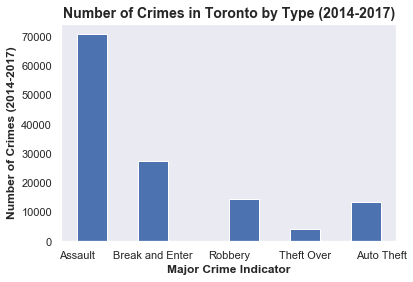

In [4]:
# Histogram by Type of Crime
sb.set()
plt.hist(crime_type_list)
plt.title('Number of Crimes in Toronto by Type (2014-2017)', fontsize = 14, fontweight = 'bold')
plt.xlabel('Major Crime Indicator', fontweight = 'bold')
plt.ylabel('Number of Crimes (2014-2017)', fontweight = 'bold')
plt.grid()
plt.show()

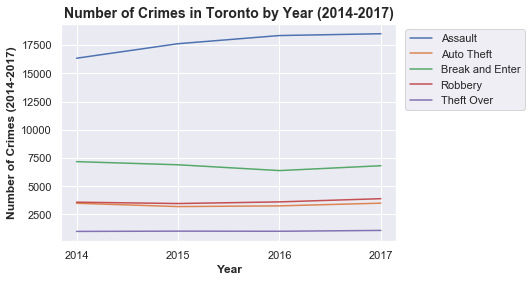

,2014,2015,2016,2017
Type,,,,
Assault,16339,17624,18347,18507
Auto Theft,3488,3194,3256,3497
Break and Enter,7175,6898,6383,6813
Robbery,3583,3464,3609,3893
Theft Over,993,1017,1006,1081


In [5]:
# Prepare data for plotting number of crimes by year
crimes_2014 = crime_df[crime_df.Date.str.startswith('2014')] # 31578 records
crimes_2015 = crime_df[crime_df.Date.str.startswith('2015')] # 32197 records
crimes_2016 = crime_df[crime_df.Date.str.startswith('2016')] # 32601 records
crimes_2017 = crime_df[crime_df.Date.str.startswith('2017')] # 33791 records
num_crimes_2014 = crimes_2014.groupby('Type').count()['Date'] 
num_crimes_2015 = crimes_2015.groupby('Type').count()['Date']
num_crimes_2016 = crimes_2016.groupby('Type').count()['Date']
num_crimes_2017 = crimes_2017.groupby('Type').count()['Date']
crime_type_by_year_df = pd.DataFrame({'2014': num_crimes_2014,
                                     '2015': num_crimes_2015,
                                     '2016': num_crimes_2016,
                                     '2017': num_crimes_2017})

# Create Line Plot of the Number of Crimes By Year
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(crime_type_by_year_df.T)
plt.title('Number of Crimes in Toronto by Year (2014-2017)', fontsize = 14, fontweight = 'bold')
plt.xlabel('Year', fontweight = 'bold')
plt.ylabel('Number of Crimes (2014-2017)', fontweight = 'bold')
leg = plt.legend(crime_type_by_year_df.index, loc = 'upper right')

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend
xOffset = 0.4
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.show()
crime_type_by_year_df

In [6]:
# WWO apikey
apikey = "c47d007910f4494b91e02126182111"

In [7]:
# Prepare lists for storing weather data
date_list = []
temp_list = []
moon_list = []
rain_list = []
years_of_interest = ['2014', '2015', '2016', '2017']
months_of_interest = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
last_day_of_month = ['31', '28', '31', '30', '31', '30', '31', '31', '30', '31', '30', '31']

for year in years_of_interest:
    for i in range(12):
        
        # Prepare start and end dates for query
        start_date = f"{year}-{months_of_interest[i]}-01"
        end_date = f"{year}-{months_of_interest[i]}-{last_day_of_month[i]}"
        
        # Prepare url (24hr average)
        weather_url = f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={apikey}&q=Toronto&format=json&date={start_date}&enddate={end_date}&tp=24"
        
        # Request and store json data
        data = requests.get(weather_url).json()
        
        for days in range(len(data['data']['weather'])):
            # Date
            date_list.append(data['data']['weather'][day]['date'])

            # Temperature
            temp_list.append(data['data']['weather'][day]['hourly'][0]['tempC'])

            # Precipitation
            rain_list.append(data['data']['weather'][day]['hourly'][0]['precipMM'])

            # Moon_phase
            moon_list.append(data['data']['weather'][day]['astronomy'][0]['moon_phase'])

# Store lists into a dataframe
weather_df = pd.DataFrame({'Date': date_list,
                          'Temp': temp_list,
                          'Precip': rain_list,
                          'Moon Phase': moon_list})

# Convert Temp and Precip in dataframe to floats
weather_df['Temp'] = pd.to_numeric(weather_df['Temp'], errors='ignore')
weather_df['Precip'] = pd.to_numeric(weather_df['Precip'], errors='ignore')

weather_df.head()

,Date,Temp,Precip,Moon Phase
0,2014-01-01,-8,0.9,Waning Crescent
1,2014-01-02,-13,3.1,Waning Crescent
2,2014-01-03,-14,0.2,Waning Crescent
3,2014-01-04,2,0.5,Waning Crescent
4,2014-01-05,2,12.5,Waning Crescent


In [45]:
#save a csv for better manipulation
df_merged = pd.merge(crime_df,weather_df,how='left', on='Date').dropna()
df_merged.head()
df_merged.to_csv("df_merged.csv")

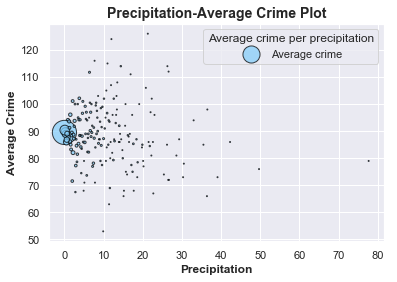

In [69]:
df=pd.read_csv("df_merged.csv")
precip_count=[]
crime_count=[]
count_num=0
for prep in list(df["Precip"].unique()):
    for item in df["Precip"]:
        if prep==item:
            count_num+=1
    crime_count.append(count_num)
    count_num=0                       
new_df=df.groupby(["Precip","Date"])["Type"].count().reset_index()
for prep in list(df["Precip"].unique()):
    for item in new_df["Precip"]:
        if prep==item:
            count_num+=1
    precip_count.append(count_num)
    count_num=0
precip_sum=pd.DataFrame({
                        "Precipitation":list(df["Precip"].unique()),
                        "Total crimes":crime_count,
                        "Number of days":precip_count})
precip_sum["Average crime"]=precip_sum["Total crimes"]/precip_sum["Number of days"]
precip_sum.head()
plt.scatter(precip_sum["Precipitation"],precip_sum["Average crime"],marker="o",facecolors="lightskyblue", edgecolors="black",
            s=precip_sum["Number of days"],alpha=0.75)
plt.title("Precipitation-Average Crime Plot",fontweight = 'bold', fontsize = 14)
plt.xlabel("Precipitation",fontweight="bold")
plt.ylabel("Average Crime",fontweight="bold")
plt.legend(title="Average crime per precipitation")
plt.show()

In [55]:
precip_sum.head()

,Precipitation,Total crimes,Number of days,Average crime
0,3.1,677,8,84.625000
1,2.2,1231,15,82.066667
2,1.1,2163,25,86.520000
3,0.4,3551,40,88.775000
4,2.9,541,7,77.285714


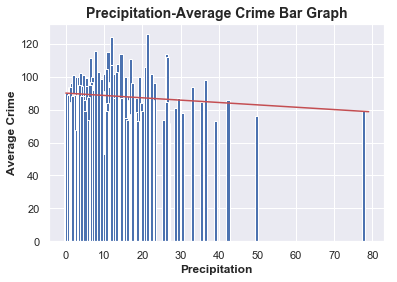

In [47]:
#plot bar graph for Precipitation-Average Crime
plt.bar(precip_sum["Precipitation"],precip_sum["Average crime"])
plt.title("Precipitation-Average Crime Bar Graph",fontweight = 'bold', fontsize = 14)
plt.xlabel("Precipitation",fontweight="bold")
plt.ylabel("Average Crime",fontweight="bold")
slope, intercept, rvalue, pvalue, _ = stats.linregress(precip_sum["Precipitation"], precip_sum["Average crime"])
x = np.arange(0, 80)
y = slope*x + intercept
plt.plot(x, y, color = 'r')
plt.show()

In [48]:
# Print R-Squared
print(f"R-Squared = {round(rvalue**2,3)}")

R-Squared = 0.017


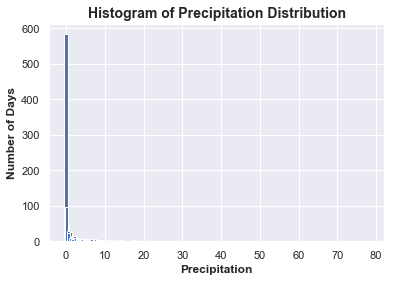

In [52]:
# Group weather dataframe by temperature bins, counting the number of days in each bucket
num_days_in_temp_bins = weather_df.groupby(['Temp'])['Date'].count()

# Plot bar graph of temperature distribution
plt.title('Histogram of Precipitation Distribution', fontweight = 'bold', fontsize = 14)
plt.xlabel('Precipitation', fontweight = 'bold')
plt.ylabel('Number of Days', fontweight = 'bold')
plt.bar(precip_sum["Precipitation"],precip_sum["Number of days"])
#plt.scatter(precip_sum["Precipitation"],precip_sum["Number of days"],marker="o",facecolors="lightskyblue", edgecolors="black",
            #s=precip_sum["Number of days"],alpha=0.75)
plt.show()

In [61]:
#form a dataframe for average number of crimes per day
df.groupby(["Precip"])["Type"].count()
df.groupby(["Precip"])["Date"].count()
df_2=pd.DataFrame({
                "Total Crimes": df.groupby("Precip")["Type"].count(),
                "Number of days": weather_df.groupby("Precip")["Date"].count(),
                "Average number of crimes committed": round(df.groupby("Precip")["Type"].count()/weather_df.groupby("Precip")["Date"].count())
                })
df_2.head()

,Total Crimes,Number of days,Average number of crimes committed
Precip,,,
0.0,52286,584,90.0
0.1,8678,96,90.0
0.2,5302,59,90.0
0.3,4271,48,89.0
0.4,3551,40,89.0


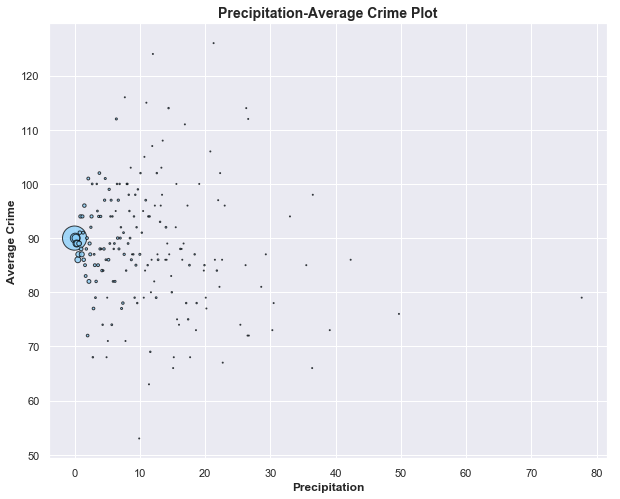

In [67]:
#plot precipitation average crime graph
plt.figure(figsize = (10,8))
plt.scatter(df_2.index,df_2["Average number of crimes committed"],marker="o",facecolors="lightskyblue", edgecolors="black",
            s=df_2["Number of days"],alpha=0.75)
plt.title("Precipitation-Average Crime Plot",fontweight = 'bold', fontsize = 14)
plt.xlabel("Precipitation",fontweight="bold")
plt.ylabel("Average Crime",fontweight="bold")
plt.savefig('Precipitation-Average Crime Plot', dpi=199)
plt.show()

In [71]:
#form a dataframe for different type of crimes and days based on precip
grouped_by_precip=df.groupby(["Precip","Type"])["Date"].count()
grouped_by_precip_df=pd.DataFrame(grouped_by_precip.reset_index())
grouped_by_precip_df.columns=["Precipitate","Crime Type","Number of Crimes"]
grouped_by_precip_df.head()
grouped_by_precip_df2=grouped_by_precip_df.pivot(index="Precipitate",columns="Crime Type",values="Number of Crimes")
grouped_by_precip_df2["Number of days"]=df_2["Number of days"]
grouped_by_precip_df2.head()

Crime Type,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,Number of days
Precipitate,,,,,,
0.0,28411.0,5426.0,10877.0,5936.0,1636.0,584
0.1,4845.0,888.0,1705.0,965.0,275.0,96
0.2,2819.0,550.0,1215.0,543.0,175.0,59
0.3,2341.0,442.0,890.0,441.0,157.0,48
0.4,1846.0,358.0,813.0,422.0,112.0,40


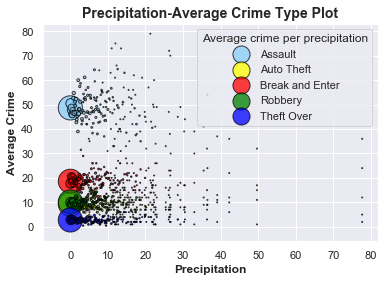

In [80]:
#Plot scatter graph for different type of crimes
plt.scatter(grouped_by_precip_df2.index,grouped_by_precip_df2["Assault"]/grouped_by_precip_df2["Number of days"],marker="o",facecolors="lightskyblue", edgecolors="black",
            s=grouped_by_precip_df2["Number of days"],label="Assault",alpha=0.75)
plt.scatter(grouped_by_precip_df2.index,grouped_by_precip_df2["Auto Theft"]/grouped_by_precip_df2["Number of days"],marker="o",facecolors="yellow", edgecolors="black",
            s=grouped_by_precip_df2["Number of days"],label="Auto Theft",alpha=0.75)
plt.scatter(grouped_by_precip_df2.index,grouped_by_precip_df2["Break and Enter"]/grouped_by_precip_df2["Number of days"],marker="o",facecolors="red", edgecolors="black",
            s=grouped_by_precip_df2["Number of days"],label="Break and Enter",alpha=0.75)
plt.scatter(grouped_by_precip_df2.index,grouped_by_precip_df2["Robbery"]/grouped_by_precip_df2["Number of days"],marker="o",facecolors="green", edgecolors="black",
            s=grouped_by_precip_df2["Number of days"],label="Robbery",alpha=0.75)
plt.scatter(grouped_by_precip_df2.index,grouped_by_precip_df2["Theft Over"]/grouped_by_precip_df2["Number of days"],marker="o",facecolors="blue", edgecolors="black",
            s=grouped_by_precip_df2["Number of days"],label="Theft Over",alpha=0.75)
plt.title("Precipitation-Average Crime Type Plot",fontweight = 'bold', fontsize = 14)
plt.xlabel("Precipitation",fontweight="bold")
plt.ylabel("Average Crime",fontweight="bold")
plt.legend(title="Average crime per precipitation")
plt.savefig('Precipitation-Average Crime Type Plot', dpi=199)
plt.show()
